../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

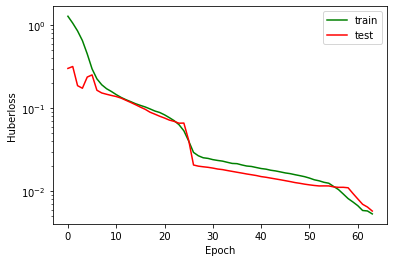

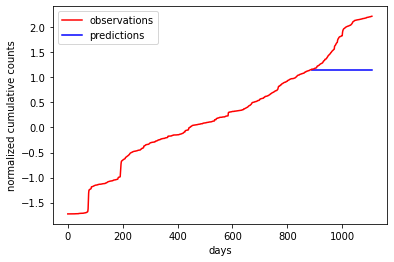

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from saif.ml_utils.data_utils import daily_seismic_and_interpolated_pressure
from saif.scinet.dataset import construct_time_series_dataset
import saif.scinet.model as scinet

_FUNCS = {
    'abs' : lambda x : x.abs(),
    'quad' : lambda x : x ** 2,
    'relu' : F.relu,
    'exp' : torch.exp,
    'sigmoid' : torch.sigmoid,
    'no_func' : lambda x : x
}

class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size,
        monotonic_fn=lambda x : x
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )

        self.monotonic_fn = monotonic_fn
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforce monotonicity
        out = self.monotonic_fn(out)

        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

def load_data(config):
    datapath = config.datapath
    
    seismic = pd.read_csv(os.path.join(datapath, 'seismic.csv'))
    pressure = pd.read_csv(os.path.join(datapath, 'pressure.csv'))

    # features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)
    features, t0 = daily_seismic_and_interpolated_pressure(seismic, pressure)
    features['seismic'] = features.target
    target_vals = features.seismic

    if config.feature_set == 'full':
        feature_names = features.columns
    elif config.feature_set == 'injection':
        feature_names = ['pressure','dpdt','seismic']
    else:
        feature_names = ['seismic']

    train_dset, test_dset, _, _ = construct_time_series_dataset(
        features, target_vals, 
        config.input_len, config.horizon, feature_names, 
        train_test_split=config.train_test_split, normalize_data=True
    )

    train_loader = DataLoader(
        train_dset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=1
    )

    test_loader = DataLoader(
        test_dset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=1
    )

    input_dim = train_dset.X.shape[1]

    return input_dim, train_loader, test_loader

def build_model(input_dim, config):
    _func = _FUNCS.get(config.monotonic_activation)

    return SimpleSCINet(
        input_len=config.input_len, output_len=config.horizon,
        input_dim=input_dim, num_levels=config.num_levels, 
        kernel_size=config.kernel_size, dropout=config.dropout, 
        groups=1, hidden_size=config.hidden_size,
        monotonic_fn=_func
    )

def train_step(device, criterion, model, optimizer, train_loader):
    model.train()
    loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        loss_vals.append(loss.item())

    return np.mean(loss_vals)

def test_step(device, criterion, model, test_loader):
    model.eval()
    loss_vals = []
    for (batch_x, batch_y) in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss_vals.append(loss.item())

    return np.mean(loss_vals)

def run_exp(config=None):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    
    torch.manual_seed(config.seed)
    input_dim, train_loader, test_loader = load_data(config)
    model = build_model(input_dim, config)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.HuberLoss()

    train_loss_vals = []
    test_loss_vals = []

    for epoch in range(config.n_epoch):
        train_loss = train_step(device, criterion, model, optimizer, train_loader)
        test_loss = test_step(device, criterion, model, test_loader)
        train_loss_vals.append(train_loss)
        test_loss_vals.append(test_loss)
    return train_loss_vals, test_loss_vals, model


def default_val(name, vals):
    if isinstance(vals, list):
        return {name : {'values' : vals}}
    else:
        return {name : {'value' : vals}}

def make_scinet_config():
    # Hyperparameters
    # returns a dictionary 
    parameters_dict = {}

    parameters_dict['seed']=0
    parameters_dict['datapath']= '../../../temporal_datasets/kansas/loc5/'
    parameters_dict['feature_set'] = 'injection'
    parameters_dict['input_len'] = 64
    parameters_dict['horizon'] = 7
    parameters_dict['train_test_split'] = .8
    parameters_dict['batch_size'] = 64
    parameters_dict['num_levels'] = 3
    parameters_dict['kernel_size'] = 4
    parameters_dict['dropout'] = 0.8
    parameters_dict['hidden_size'] = 3
    parameters_dict['monotonic_activation'] = 'relu'
    parameters_dict['lr'] = 0.001
    parameters_dict['n_epoch'] = 64
    return parameters_dict

class Struct:
    # Turn dictionary into a struct
    def __init__(self, **entries):
        self.__dict__.update(entries)

# config = Struct(**make_scinet_config())


def saveplot(train_loss_vals,test_loss_vals,savefile=True,filename='training_curve.csv'):
    import matplotlib.pyplot as plt
    train_loss_vals
    test_loss_vals
    plt.plot(train_loss_vals, color='g', label='train')
    plt.plot(test_loss_vals, color='r', label='test')
    plt.legend()
    plt.ylabel('Huberloss')
    # plt.ylim([0,2])
    plt.yscale('log')
    plt.xlabel('Epoch')
    if savefile:
        pd.DataFrame({
            'epoch_number':range(len(train_loss_vals)),
            'train_loss': train_loss_vals,
            'test_loss':test_loss_vals
        }).to_csv(filename,index=False)

def monte_carlo_sample(model, x, n_samples=50, seed=0):
    torch.manual_seed(seed)
    model.train()
    # We want the model to be in training mode
    # Except for the BN.
    # There is potentially a more elegant way to do this
    # Ex by making a different "mode" in our own model groups
    model.bn1.training = False
    model.bn2.training = False
    
    samples = []
    for _ in range(n_samples):
        samples.append(model(x).data)
    samples = torch.stack(samples)
    
    model.eval()
    return samples.permute(1, 0, 2)

def monte_carlo(model,config):
    datapath = config.datapath
        
    seismic = pd.read_csv(os.path.join(datapath, 'seismic.csv'))
    pressure = pd.read_csv(os.path.join(datapath, 'pressure.csv'))

    # features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)
    features, t0 = daily_seismic_and_interpolated_pressure(seismic, pressure)
    features['seismic'] = features.target
    target_vals = features.seismic

    if config.feature_set == 'full':
        feature_names = features.columns
    elif config.feature_set == 'injection':
        feature_names = ['pressure','dpdt','seismic']
    else:
        feature_names = ['seismic']

    train_dset, test_dset, _, _ = construct_time_series_dataset(
        features, target_vals, 
        config.input_len, config.horizon, feature_names, 
        train_test_split=config.train_test_split, normalize_data=True
    )

    train_loader = DataLoader(
        train_dset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=1
    )

    test_loader = DataLoader(
        test_dset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=1
    )

    start_input = 0
    end_input = start_input + config.input_len
    end_output = end_input + config.horizon


    sample_x = torch.clone(test_dset.X[start_input:end_input])
    input_y = torch.clone(test_dset.Y[start_input:end_input+1])
    output_y = torch.clone(test_dset.Y[end_input:end_output])

   

    model.eval()
    pred_y = model(sample_x[None, :, :]).squeeze(0).data

    samples = monte_carlo_sample(model, sample_x[None, :, :], n_samples=10)
    samples = samples.squeeze(0).data.numpy()

    sample_mean = samples.mean(0)
    sample_std = samples.std(0)

    ## You can use mean +/- std, or percentile, to visualize the distribtion

    # Uncomment to use mean +/- std
    #sample_ub = sample_mean + sample_std
    #sample_lb = sample_mean - sample_std

    # Use percentiles
    sample_ub = np.percentile(samples, 90, axis=0)
    sample_lb = np.percentile(samples, 10, axis=0)

    sample_max = samples.max(0)
    sample_min = samples.min(0)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    ax.plot(np.arange(start_input, end_input+1), input_y, 'r', marker='o', label='observed')
    ax.plot(np.arange(end_input, end_output), output_y, 'r', marker='o')
    ax.fill_between(np.arange(end_input, end_output), sample_ub, sample_lb, alpha=0.1, color='b')
    ax.fill_between(np.arange(end_input, end_output), sample_max, sample_min, alpha=0.05, color='b')
    ax.plot(np.arange(end_input, end_output), pred_y, 'b', marker='o', label='forecast')

    plt.xlabel('days')
    plt.ylabel('normalized cumulative counts')
    plt.legend(loc='lower right')
    plt.show()
    plt.close()

def multiple_horizons(model,config,savefile=True,filename='test_pred.csv'): 
    datapath = config.datapath
        
    seismic = pd.read_csv(os.path.join(datapath, 'seismic.csv'))
    pressure = pd.read_csv(os.path.join(datapath, 'pressure.csv'))

    # features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)
    features, t0 = daily_seismic_and_interpolated_pressure(seismic, pressure)
    features['seismic'] = features.target
    target_vals = features.seismic

    if config.feature_set == 'full':
        feature_names = features.columns
    elif config.feature_set == 'injection':
        feature_names = ['pressure','dpdt','seismic']
    else:
        feature_names = ['seismic']

    train_dset, test_dset, _, _ = construct_time_series_dataset(
        features, target_vals, 
        config.input_len, config.horizon, feature_names, 
        train_test_split=config.train_test_split, normalize_data=True
    )

    train_loader = DataLoader(
        train_dset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=1
    )

    test_loader = DataLoader(
        test_dset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=1
    )
    
    start_input = 0
    n_horizons_forcast = len(test_dset.Y) // config.horizon + 1
    end_input = start_input + config.input_len
    end_output = end_input + n_horizons_forcast*config.horizon
    sample_x = torch.clone(train_dset.X[-config.input_len:])
    input_y = torch.clone(train_dset.Y[-config.input_len:])
    forecast_X = torch.cat((torch.clone(train_dset.X[-config.input_len:]),torch.clone(test_dset.X)))
    output_y = torch.clone(test_dset.Y[:-1])

    torch.manual_seed(0)
    model.eval()
    predictions = []
    outputs_y = []
    sample_x = torch.clone(forecast_X[start_input:end_input])
    for i in range(n_horizons_forcast):
        _predict = model(sample_x[None,:,:])
        predictions.append(_predict.data.squeeze()) # output?
        sample_x = torch.clone(forecast_X[start_input+i*config.horizon:end_input+i*config.horizon])
        sample_x[None,-config.horizon:,-1] = _predict.data.squeeze()
    plt.figure()
    plt.plot(np.arange(0,len(train_dset.Y)),train_dset.Y,'r',label='observations')
    plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(torch.cat(predictions))),torch.cat(predictions).squeeze(),'b',label='predictions')
    plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(output_y)),output_y,'r')
    plt.legend()
    plt.xlabel('days')
    plt.ylabel('normalized cumulative counts')
    plt.show()
    plt.close()
    if savefile == True:
        pd.DataFrame({
            'days':np.arange(len(train_dset.Y),len(train_dset.Y)+len(output_y)),
            'y_test': output_y,
            'pred_test':torch.cat(predictions).squeeze()[:len(output_y)]
        }).to_csv(filename,index=False)

def multiple_horizons_unrolling_one(model,config,savefile=True,filename='test_pred.csv'): 
    datapath = config.datapath
        
    seismic = pd.read_csv(os.path.join(datapath, 'seismic.csv'))
    pressure = pd.read_csv(os.path.join(datapath, 'pressure.csv'))

    # features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)
    features, t0 = daily_seismic_and_interpolated_pressure(seismic, pressure)
    features['seismic'] = features.target
    target_vals = features.seismic

    if config.feature_set == 'full':
        feature_names = features.columns
    elif config.feature_set == 'injection':
        feature_names = ['pressure','dpdt','seismic']
    else:
        feature_names = ['seismic']

    train_dset, test_dset, _, _ = construct_time_series_dataset(
        features, target_vals, 
        config.input_len, config.horizon, feature_names, 
        train_test_split=config.train_test_split, normalize_data=True
    )

    train_loader = DataLoader(
        train_dset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=1
    )

    test_loader = DataLoader(
        test_dset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=1
    )
    
    start_input = 0
    # n_horizons_forcast = len(test_dset.Y) // config.horizon + 1
    end_input = start_input + config.input_len
    sample_x = torch.clone(train_dset.X[-config.input_len:])
    input_y = torch.clone(train_dset.Y[-config.input_len:])
    forecast_X = torch.cat((torch.clone(train_dset.X[-config.input_len:]),torch.clone(test_dset.X)))
    output_y = torch.clone(test_dset.Y[:-1])

    torch.manual_seed(0)
    model.eval()
    predictions = []
    outputs_y = []
    sample_x = torch.clone(forecast_X[start_input:end_input])
    # for i in range(n_horizons_forcast):
    for i in range(len(test_dset.Y)):
        _predict = model(sample_x[None,:,:])
        predictions.append(_predict.data.squeeze()[0]) # output?
        # sample_x = torch.clone(forecast_X[start_input+i*config.horizon:end_input+i*config.horizon])
        # sample_x[None,-config.horizon:,-1] = _predict.data.squeeze()
        sample_x = torch.clone(forecast_X[start_input+i+1:end_input+i+1])
        sample_x[None,-1,-1] = _predict.data.squeeze()[0]
    plt.figure()
    plt.plot(np.arange(0,len(train_dset.Y)),train_dset.Y,'r',label='observations')
    plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(torch.stack(predictions))),torch.stack(predictions).squeeze(),'b',label='predictions')
    plt.plot(np.arange(len(train_dset.Y),len(train_dset.Y)+len(output_y)),output_y,'r')
    plt.legend()
    plt.xlabel('days')
    plt.ylabel('normalized cumulative counts')
    plt.show()
    plt.close()


if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons_unrolling_one(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

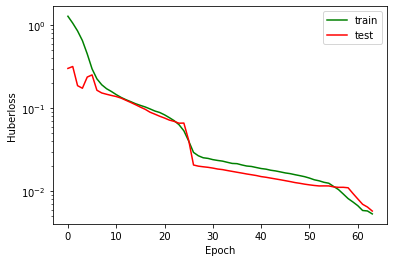

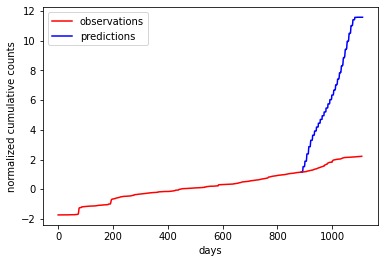

In [2]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=64
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

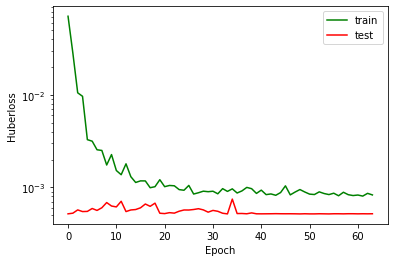

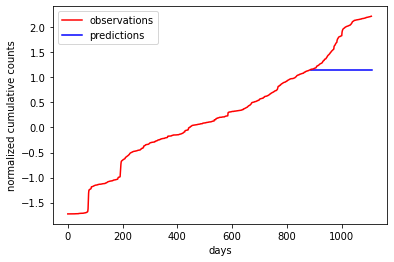

In [3]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=16
    config.hidden_size=3
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)


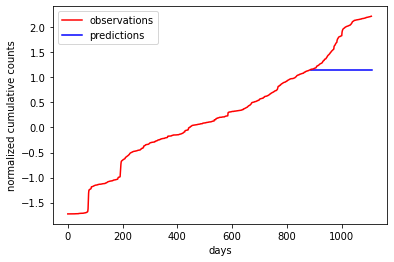

In [4]:
multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

In [5]:
plt.plot(train_dset.X[:,1])

NameError: name 'train_dset' is not defined

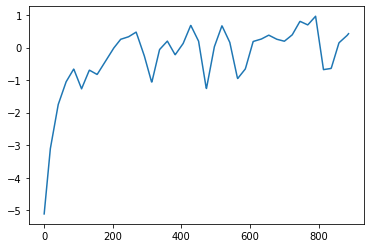

In [ ]:
plt.plot(train_dset.X[:,0])

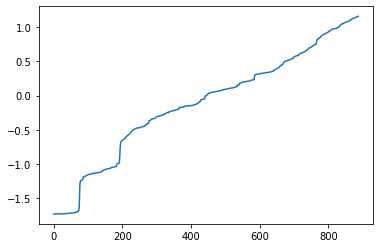

In [ ]:
plt.plot(train_dset.X[:,2])

../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

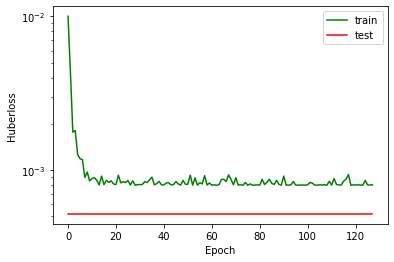

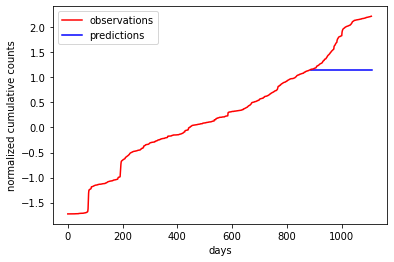

In [ ]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=16
    config.hidden_size=3
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='seismic'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

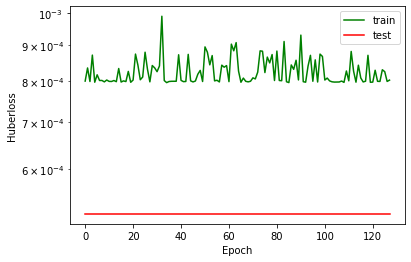

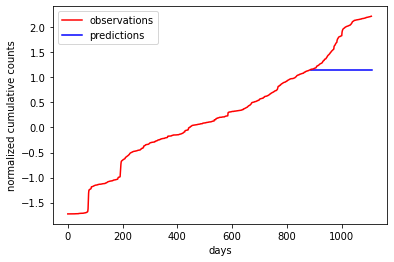

In [ ]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=16
    config.hidden_size=3
    config.kernel_size=5
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

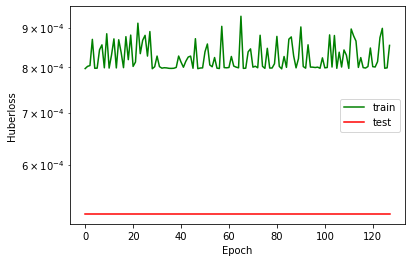

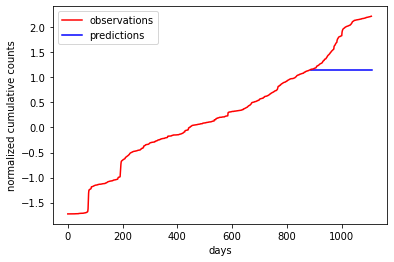

In [ ]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=16
    config.hidden_size=3
    config.kernel_size=5
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

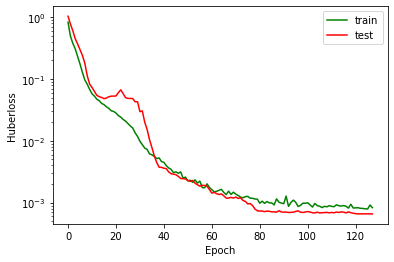

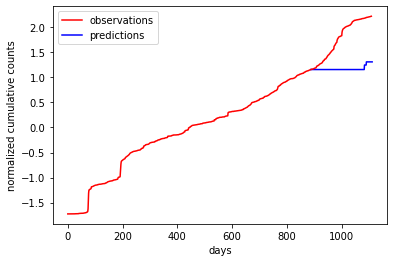

In [ ]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=32
    config.hidden_size=1
    config.kernel_size=5
    config.batch_size=32
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

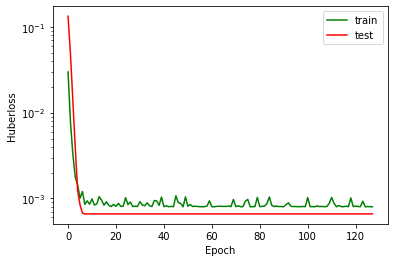

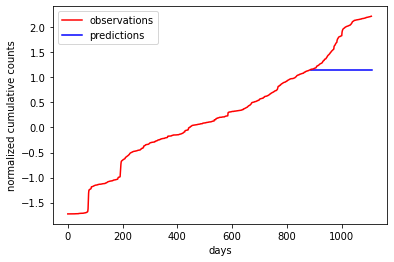

In [ ]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=32
    config.hidden_size=1
    config.kernel_size=5
    config.batch_size=32
    config.seed = 3
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/kansas/loc3/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

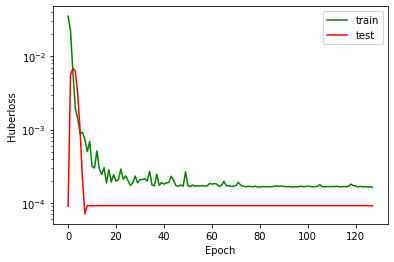

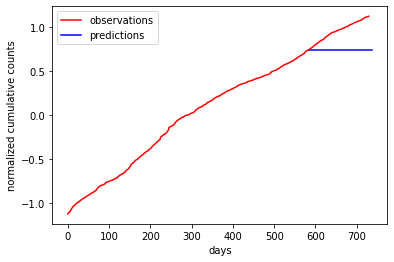

In [ ]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=32
    config.hidden_size=1
    config.kernel_size=5
    config.batch_size=32
    config.seed = 3
    config.datapath="../../../temporal_datasets/kansas/loc3/"
    # config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/cushing_2014_oklahoma/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

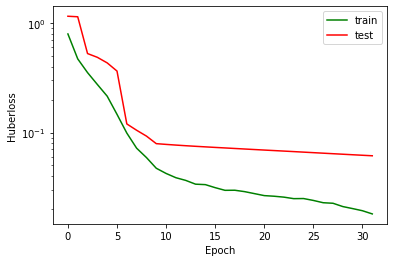

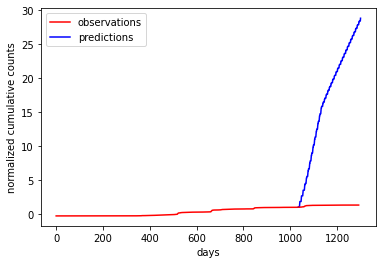

In [ ]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=32
    config.hidden_size=1
    config.kernel_size=5
    config.batch_size=32
    config.n_epoch=32
    config.seed = 0
    config.datapath="../../../temporal_datasets/cushing_2014_oklahoma/"
    # config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=False,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=False,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)


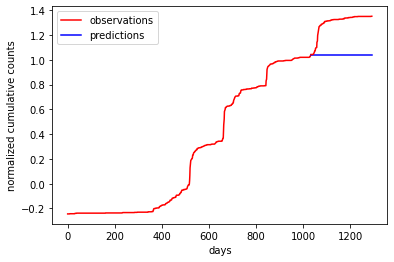

In [ ]:
multiple_horizons_unrolling_one(model,config,savefile=False,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/cushing_2014_oklahoma/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Suppo

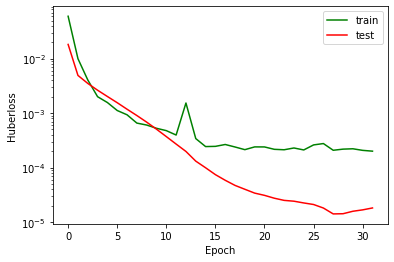

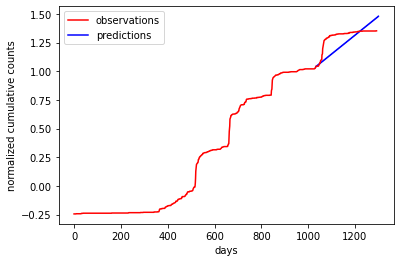

In [ ]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.8
    config.num_levels=3
    config.input_len=128
    config.hidden_size=2
    config.kernel_size=2
    config.batch_size=32
    config.n_epoch=32
    config.seed = 0
    config.datapath="../../../temporal_datasets/cushing_2014_oklahoma/"
    # config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=False,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=False,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

In [6]:
if __name__ == "__main__":
    config = Struct(**make_scinet_config())
    config.dropout = 0.4
    config.num_levels=2
    config.input_len=32
    config.hidden_size=1
    config.kernel_size=4
    config.batch_size=32
    config.seed = 3
    # config.datapath="../../../temporal_datasets/kansas/loc3/"
    config.datapath="../../../temporal_datasets/decatur_illinois/"
    config.feature_set='injection'
    config.batch_size = 64
    print(config.datapath)
    train_loss_vals, test_loss_vals, model = run_exp(config=config)
    saveplot(train_loss_vals,test_loss_vals,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_training_curve.csv')
    multiple_horizons(model,config,savefile=True,filename=config.datapath.split('/')[-3]+'_'+config.datapath.split('/')[-2] + '_test_pred.csv')

../../../temporal_datasets/decatur_illinois/


/Library/Python/3.8/site-packages/saif/scinet/dataset.py:101: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_y = y_scaler.fit_transform(train_y[:, None]).squeeze(1)
/Library/Python/3.8/site-packages/saif/scinet/dataset.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_y = y_scaler.transform(test_y[:, None]).squeeze(1)
